# Includes

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import copy

from __future__ import print_function
from sklearn.utils import shuffle
from scipy.spatial.distance import jensenshannon
import os
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils

# Set Random Seed

In [2]:
manual_seed = 1000

if manual_seed is None:
    manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
os.environ['PYTHONHASHSEED'] = str(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Random Seed:  1000


# Login to Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Dataset

In [0]:
class MixGaussian2D(torch.utils.data.Dataset):
    # mix_num : number of mixtures
    # meeans : 2d array of means
    def __init__(self, mix_num, means, size_per_mix, cov_factor=1, labels = 0):
      self.x_train = np.zeros((sum(size_per_mix), 2))
      self.y_train = np.zeros((sum(size_per_mix)))

      # Keep track of index
      idx = 0
      for i in range(mix_num):
        m = [means[i][0], means[i][1]]
        cov = [[cov_factor, 0], [0, cov_factor]]

        # Load Data 
        self.x_train[idx: idx + size_per_mix[i]] = np.random.multivariate_normal(m, cov, size_per_mix[i])
        self.y_train[idx: idx + size_per_mix[i]] = i*np.ones((size_per_mix[i], ))

        # Update index
        idx = idx + size_per_mix[i]
      
      # Shuffle data
      self.x_train, self.y_train = shuffle(self.x_train, self.y_train)

      if not labels:
        self.y_train = np.ones((sum(size_per_mix)))
        
    def __getitem__(self, index):
      return (self.x_train[index], self.y_train[index])

    def __len__(self):
      return self.x_train.shape[0]


# GAN


In [0]:

# Helper function
def reset_grad(opt):
    opt["d_optimizer"].zero_grad()
    opt["g_optimizer"].zero_grad()


In [0]:
def train_gan(ds, D, G, hyperparam, opt):  
  data_loader = torch.utils.data.DataLoader(dataset=ds,
                                          batch_size=hyperparam["batch_size"], 
                                          shuffle=True)
  # List of epochs
  e = [] 

  # List of epochs where you want to plot
  plot_epoch_list = []
  
  # Total steps in one iteration
  total_step = len(data_loader)

  # Model specific lists
  g_loss_list = []
  d_loss_list = []
  jsd_list = []

  # Training Loop
  for epoch in range(hyperparam["num_epochs"]):
    e.append(epoch)
    for i, (data_point, _) in enumerate(data_loader):
      #data_point = data_point.reshape(hyperparam["batch_size"], -1).to(hyperparam["device"])
      # Move batch on to the GPU
      data_point = data_point.to(hyperparam["device"])

      # Create the labels which are later used as input for the BCE loss
      real_labels = torch.ones(hyperparam["batch_size"], 1).to(hyperparam["device"])
      fake_labels = torch.zeros(hyperparam["batch_size"], 1).to(hyperparam["device"])

      # ================================================================== #
      #                      Train the discriminator                       #
      # ================================================================== #

      # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
      # Second term of the loss is always zero since real_labels == 1
      outputs = D(data_point.float())
      
      d_loss_real = opt["criterion"](outputs, real_labels)
      real_score = outputs
      
      # Compute BCELoss using fake images
      # First term of the loss is always zero since fake_labels == 0
      z = torch.randn(hyperparam["batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])
      fake_images = G(z)
      outputs = D(fake_images)
      d_loss_fake = opt["criterion"](outputs, fake_labels)
      fake_score = outputs
      
      # Store total loss
      d_loss = d_loss_real + d_loss_fake

      if i == total_step - 1:
          d_loss_list.append(d_loss)
      
      # Backprop and optimize
      reset_grad(opt)
      d_loss.backward()
      opt["d_optimizer"].step()
      
      # ================================================================== #
      #                        Train the generator                         #
      # ================================================================== #

      # Compute loss with fake images
      z = torch.randn(hyperparam["batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])

      fake_images = G(z)
      outputs = D(fake_images)
      
      # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
      # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
      g_loss = opt["criterion"](outputs, real_labels)
      if i == total_step - 1:
          g_loss_list.append(g_loss)

      # Backprop and optimize
      reset_grad(opt)
      g_loss.backward()
      opt["g_optimizer"].step()
      
      if (i+1) % hyperparam["print_after_batches"] == 0:
          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                .format(epoch, hyperparam["num_epochs"], i+1, total_step, d_loss.item(), g_loss.item(), 
                        real_score.mean().item(), fake_score.mean().item()))

    # Evaluation during training 
    with torch.no_grad():
      if epoch % hyperparam["plot_epoch"] == 0:
        # collect plotting epochs
        plot_epoch_list.append(epoch)

        # Plot Loss
        print("\n Epoch : {}".format(epoch))
        plt.plot(e, d_loss_list, 'b-', label = 'd_loss_real')
        plt.plot(e, g_loss_list, 'r-', label = 'g_loss')
        plt.legend()
        plt.show()

        # Sample from real data
        ds_shape = ds[:][0].shape
        ds_sample_idx = np.random.choice(ds_shape[0], hyperparam["plot_batch_size"], replace=False)
        ds_sample = ds[:][0][ds_sample_idx]

        # Sample from current model
        z_plot = torch.randn(hyperparam["plot_batch_size"], hyperparam["latent_size"]).to(hyperparam["device"])
        output_plot = G(z_plot)

        # Calculate scores
        plot_real_score = D(torch.from_numpy(ds_sample).to(hyperparam["device"]).float())
        plot_fake_score = D(output_plot)

        # Plot JS Distance
        print("\n Epoch : {}".format(epoch))
        jsd_list.append(jensenshannon(plot_real_score.cpu().detach().numpy(), plot_fake_score.cpu().detach().numpy()))
        plt.plot(plot_epoch_list, jsd_list, 'b-', label='JSD Current')
        plt.title("Jensen Shannon Distance")
        plt.legend()
        plt.show()
                      
        plt.plot(ds_sample[:, 0], ds_sample[:, 1], 'bo', label = 'Real Data')
        plt.plot(output_plot[:, 0].cpu().detach().numpy(), output_plot[:, 1].cpu().detach().numpy(), 'ro', label = 'Fake Data')
        plt.title("Samples from Current Model")
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.legend()
        plt.show()
  
  return D, G


 Epoch : 0


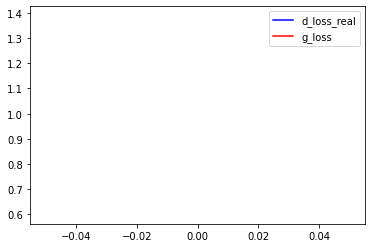


 Epoch : 0


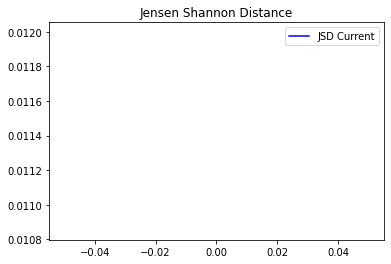

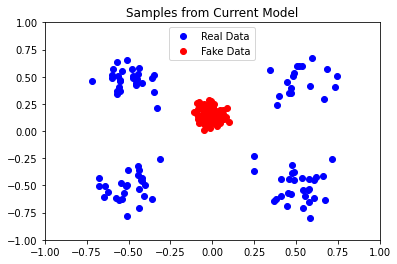


 Epoch : 100


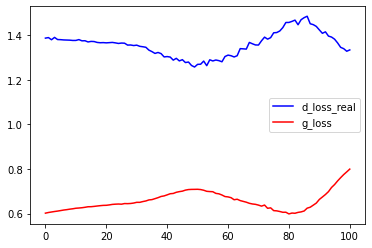


 Epoch : 100


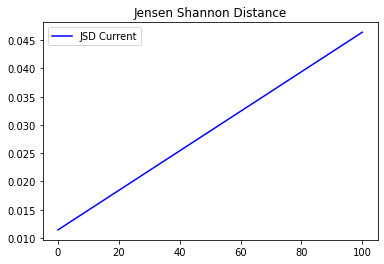

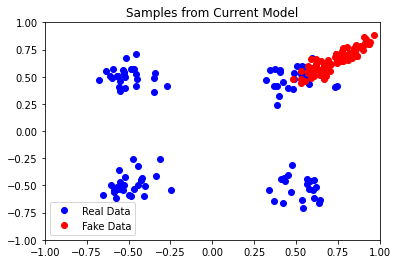


 Epoch : 200


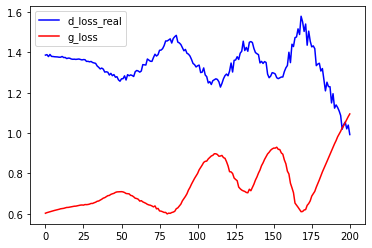


 Epoch : 200


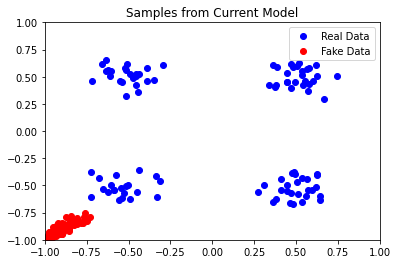


 Epoch : 300



 Epoch : 300


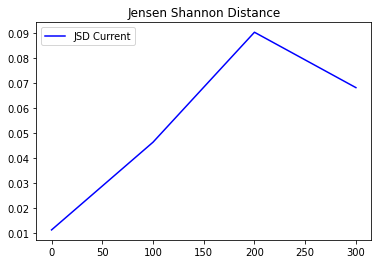

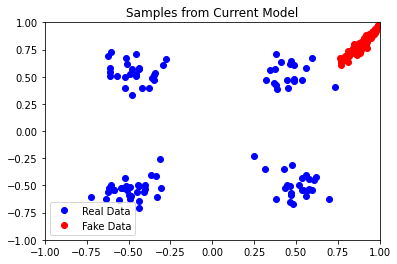


 Epoch : 400


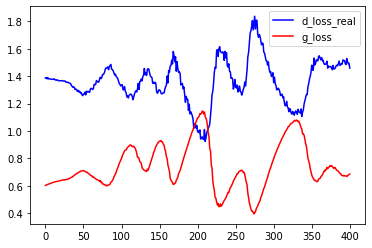


 Epoch : 400


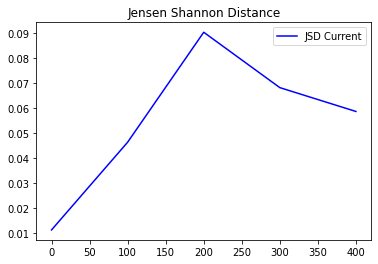

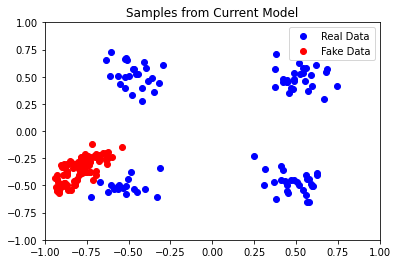


 Epoch : 500


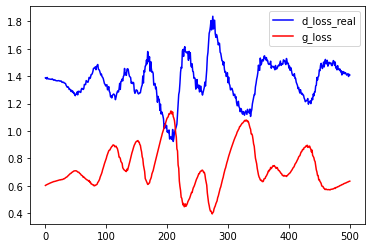


 Epoch : 500


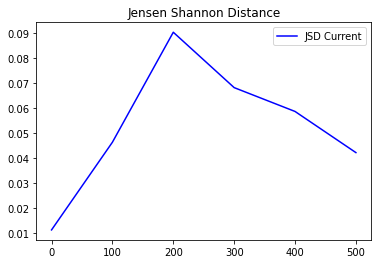

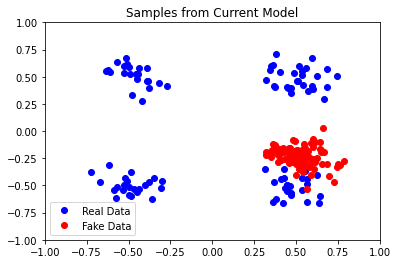


 Epoch : 600


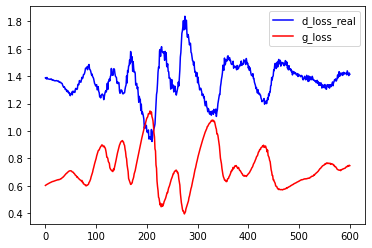


 Epoch : 600


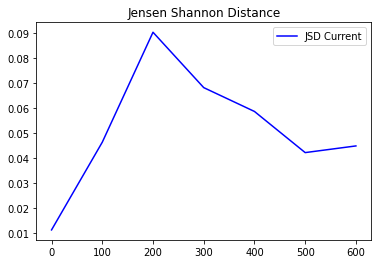

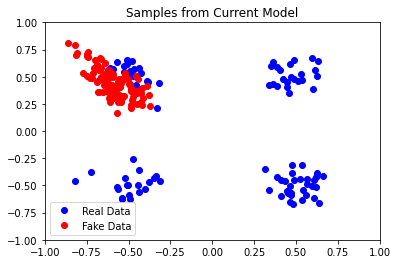


 Epoch : 700


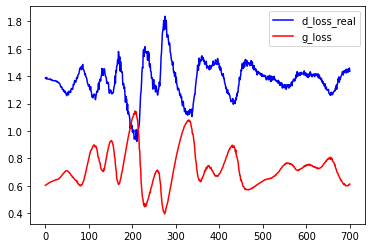


 Epoch : 700


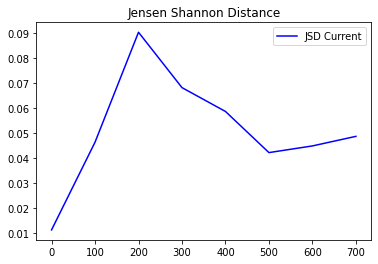

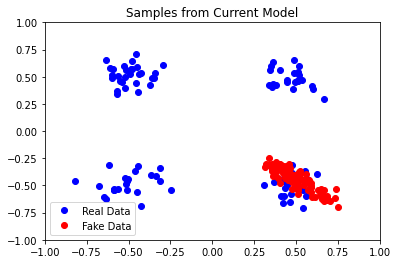


 Epoch : 800


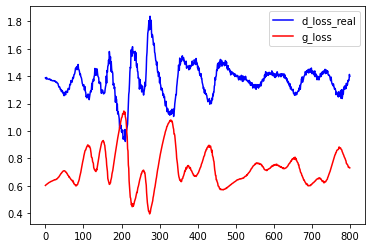


 Epoch : 800


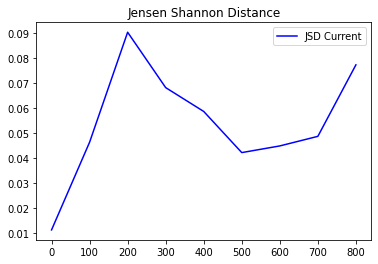

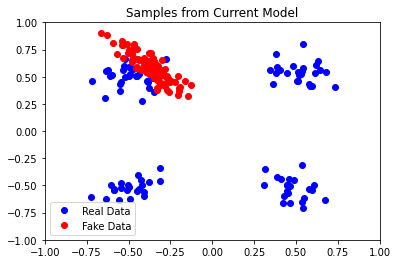


 Epoch : 900


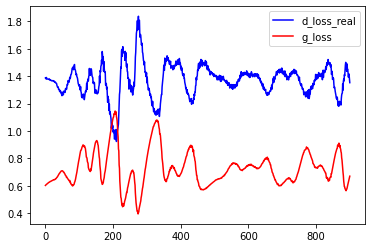


 Epoch : 900


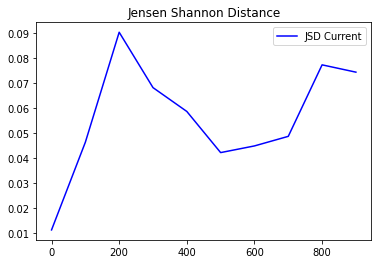

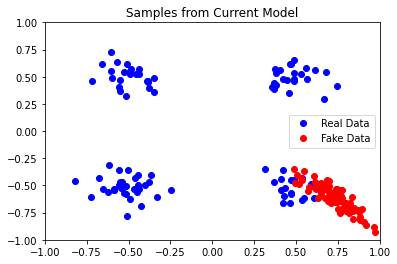


 Epoch : 1000


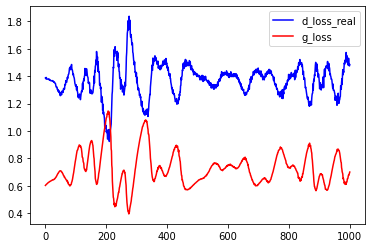


 Epoch : 1000


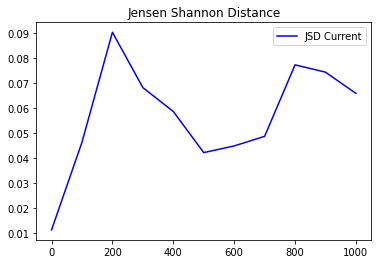

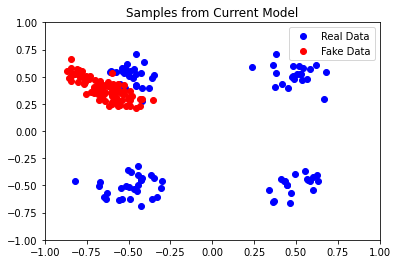


 Epoch : 1100


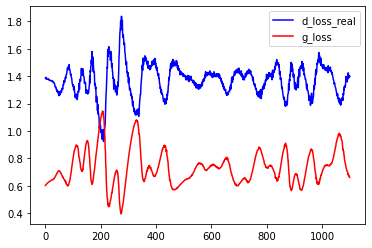


 Epoch : 1100


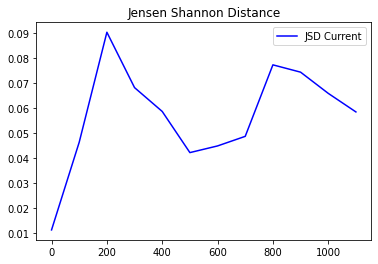

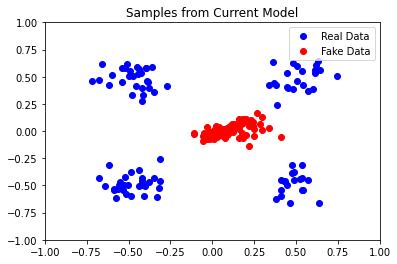


 Epoch : 1200


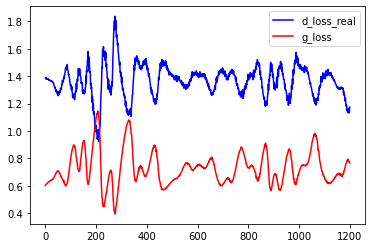


 Epoch : 1200


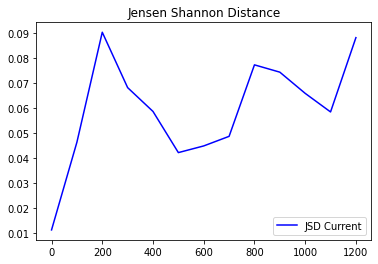

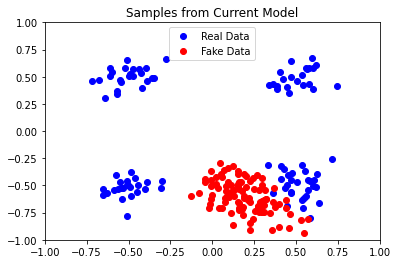


 Epoch : 1300


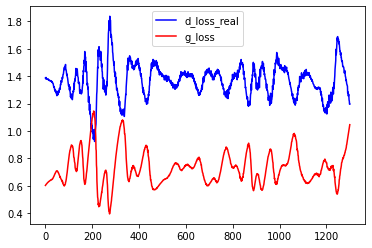


 Epoch : 1300


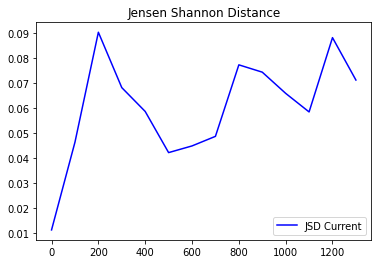

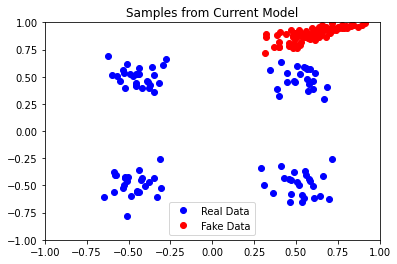


 Epoch : 1400


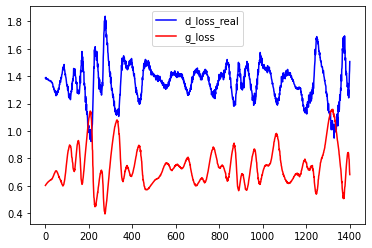


 Epoch : 1400


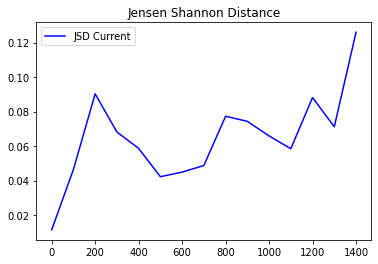

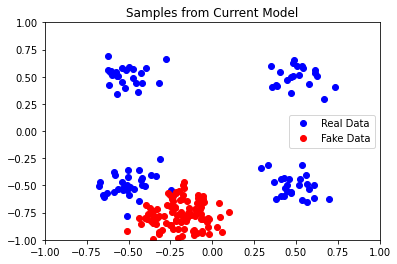


 Epoch : 1500


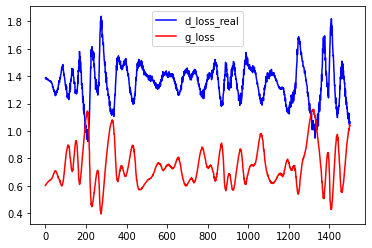


 Epoch : 1500


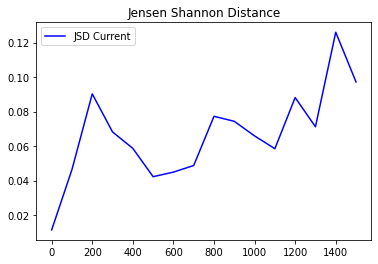

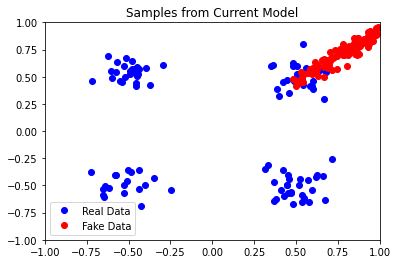


 Epoch : 1600


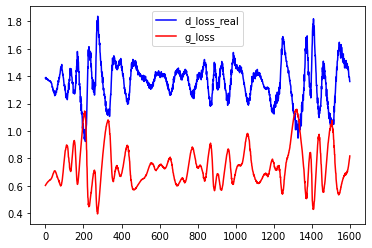


 Epoch : 1600


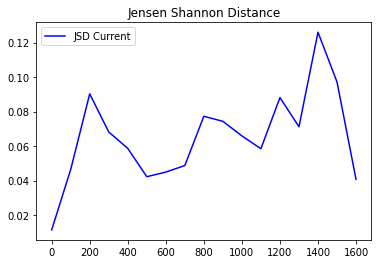

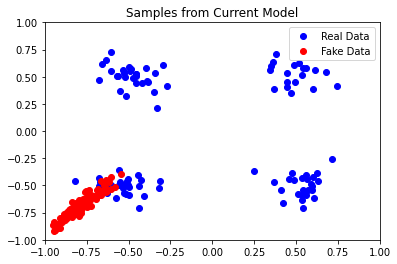


 Epoch : 1700


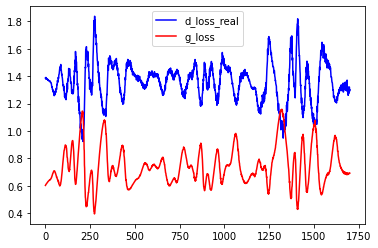


 Epoch : 1700


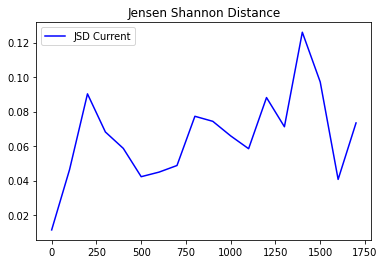

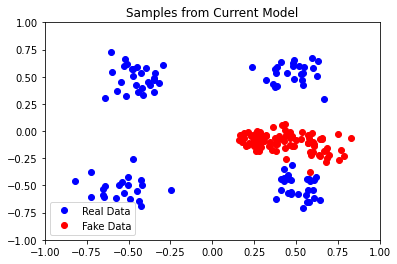


 Epoch : 1800


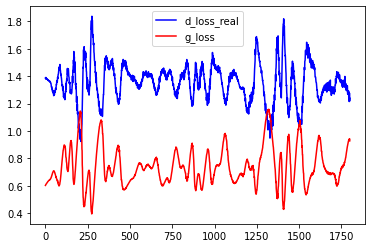


 Epoch : 1800


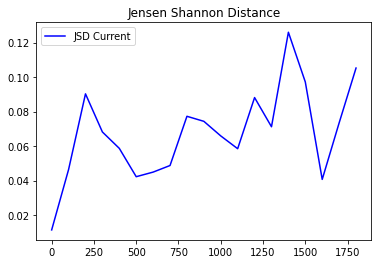

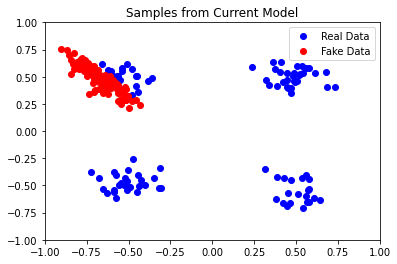


 Epoch : 1900


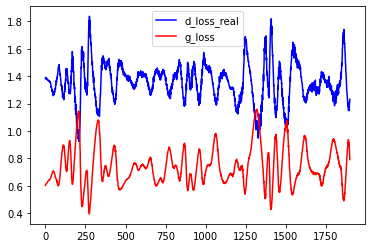


 Epoch : 1900


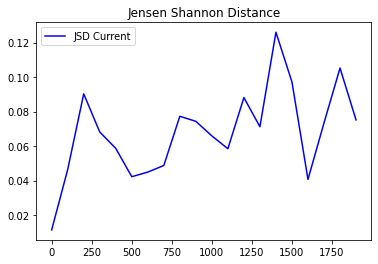

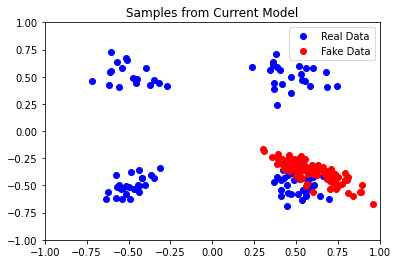


 Epoch : 2000


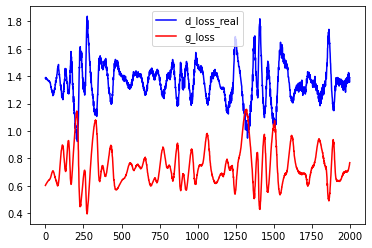


 Epoch : 2000


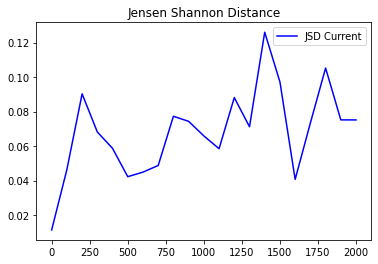

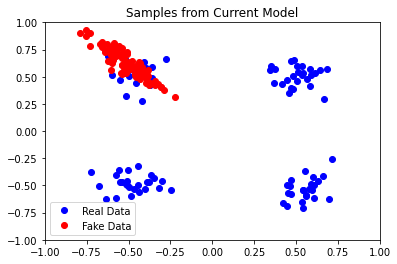


 Epoch : 2100


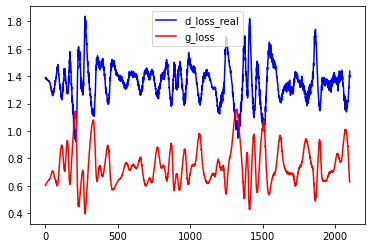


 Epoch : 2100


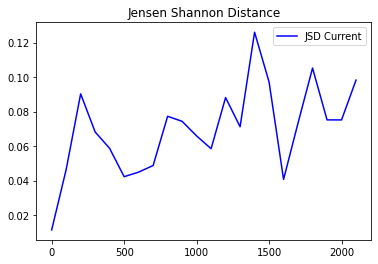


 Epoch : 2200



 Epoch : 2200


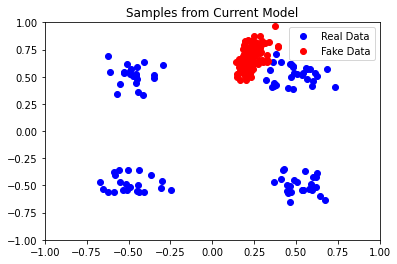


 Epoch : 2300



 Epoch : 2300


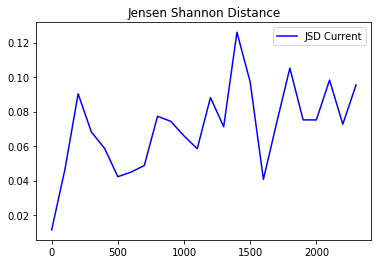

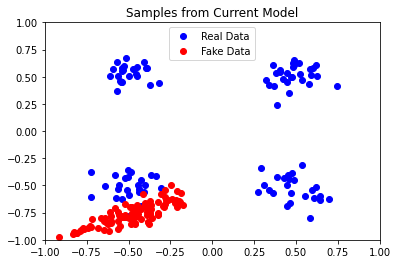


 Epoch : 2400



 Epoch : 2400


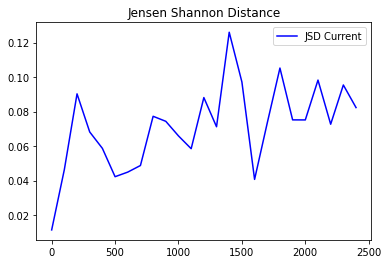


 Epoch : 2500


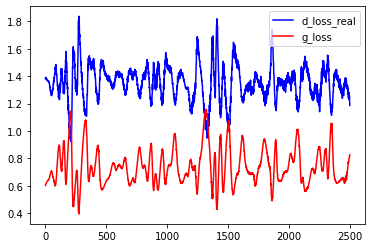


 Epoch : 2500


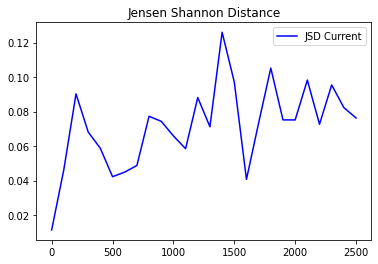

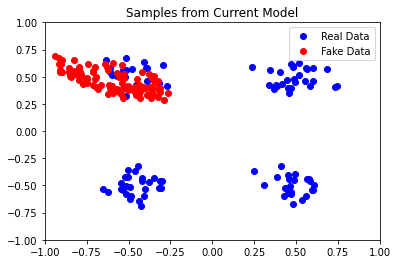


 Epoch : 2600


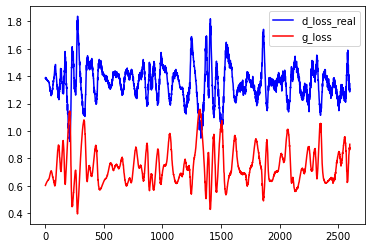


 Epoch : 2600


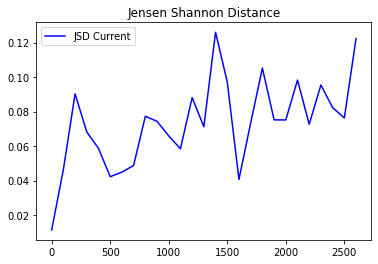

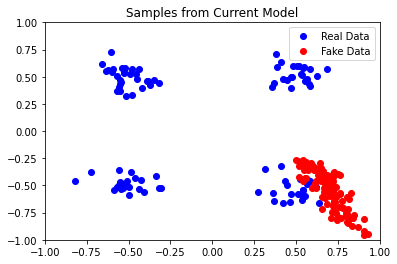


 Epoch : 2700


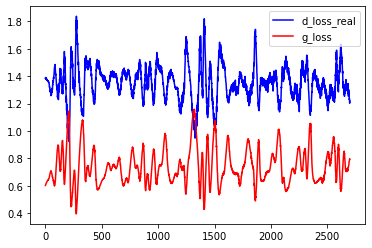


 Epoch : 2700


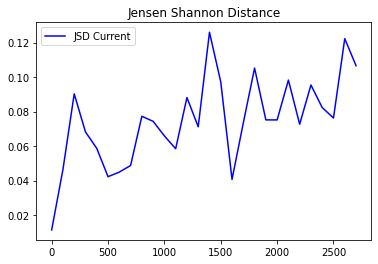

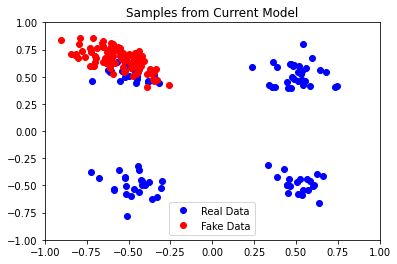


 Epoch : 2800


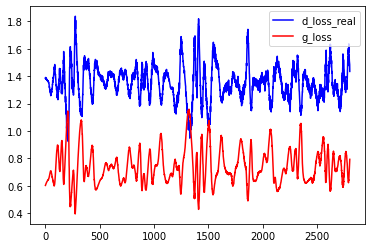


 Epoch : 2800


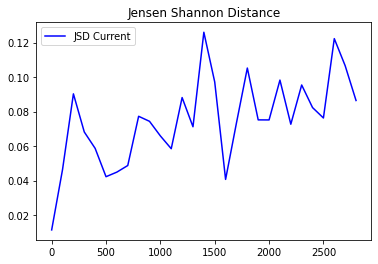

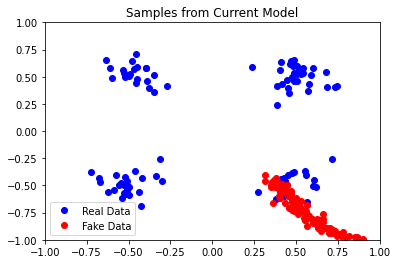


 Epoch : 2900


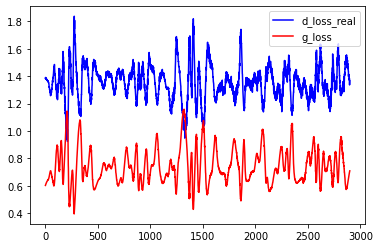


 Epoch : 2900


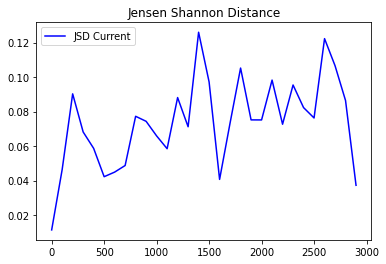

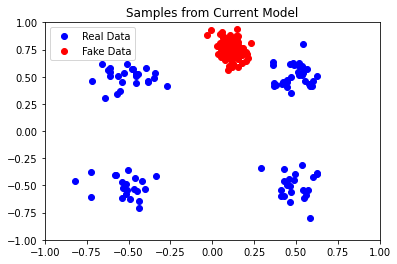


 Epoch : 3000


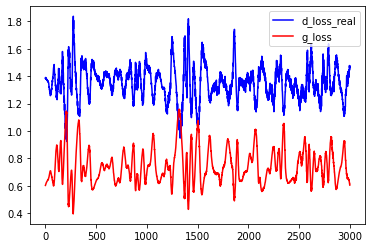


 Epoch : 3000


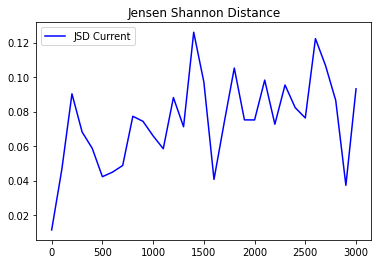

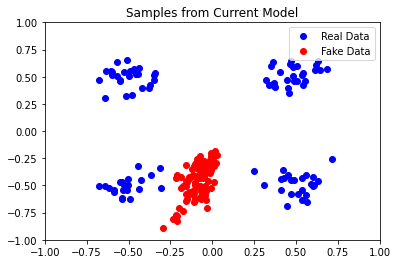


 Epoch : 3100


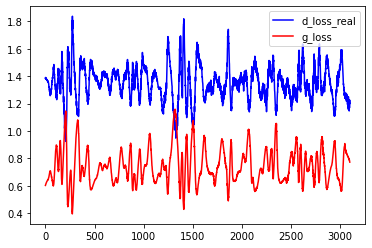


 Epoch : 3100


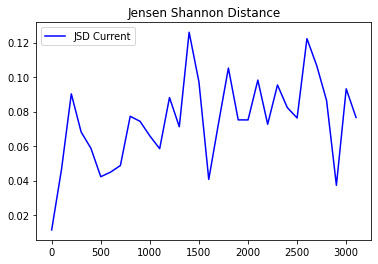

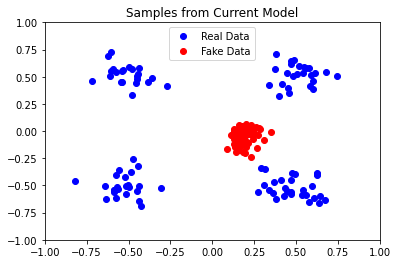


 Epoch : 3200


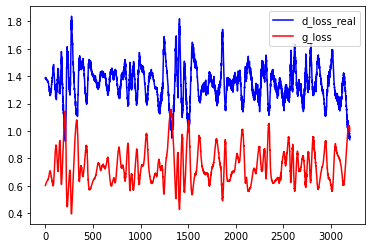


 Epoch : 3200


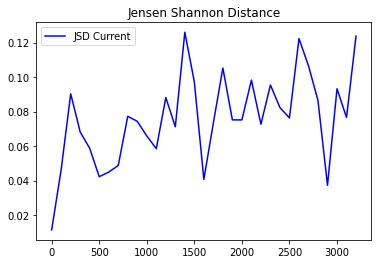

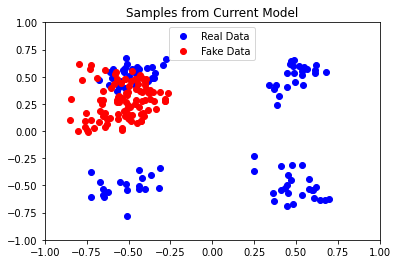


 Epoch : 3300


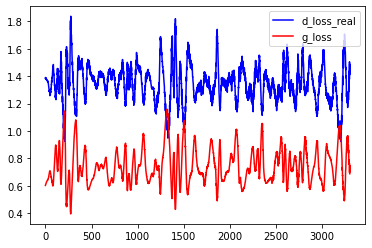


 Epoch : 3300


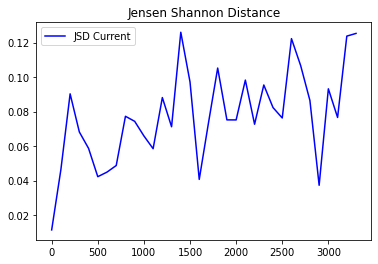

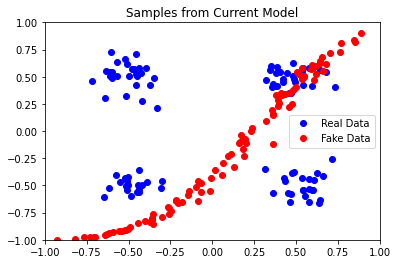


 Epoch : 3400


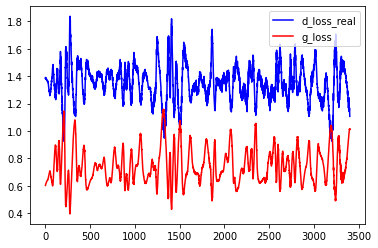


 Epoch : 3400


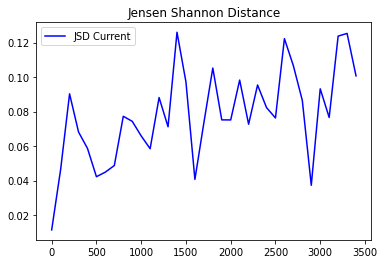

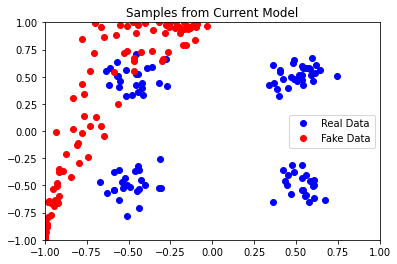


 Epoch : 3500


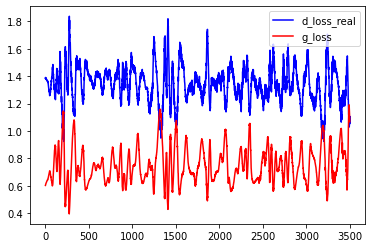


 Epoch : 3500


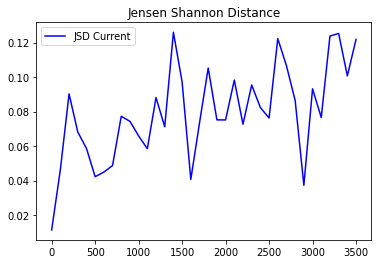

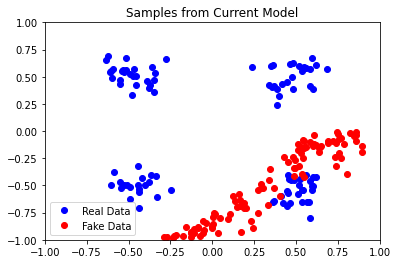


 Epoch : 3600


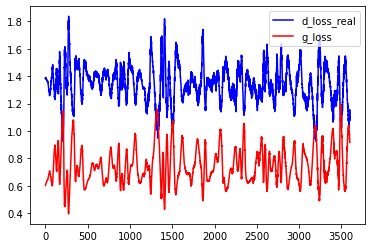


 Epoch : 3600


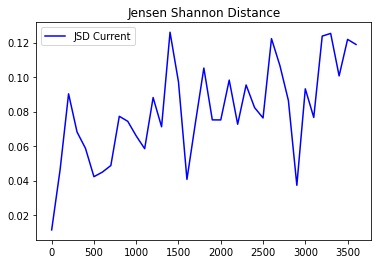

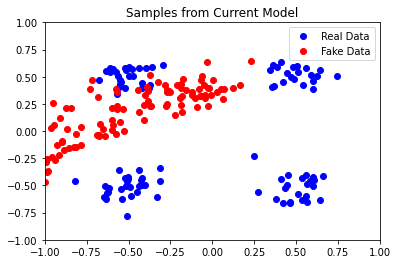


 Epoch : 3700


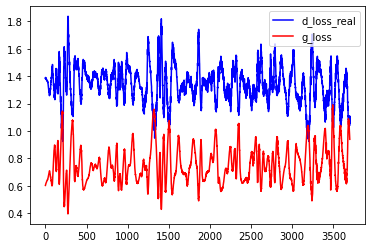


 Epoch : 3700


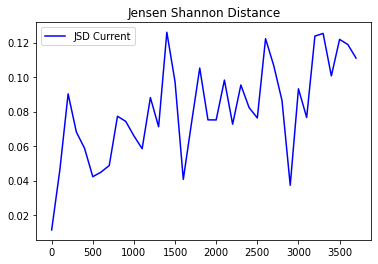

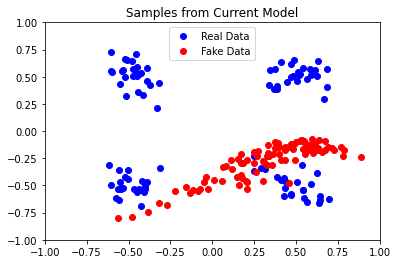


 Epoch : 3800


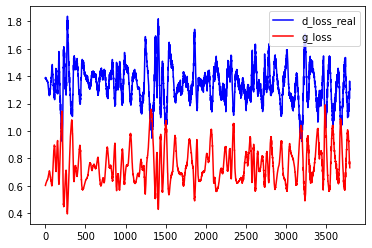


 Epoch : 3800


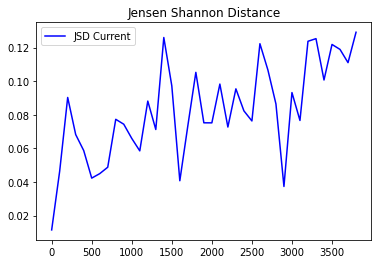

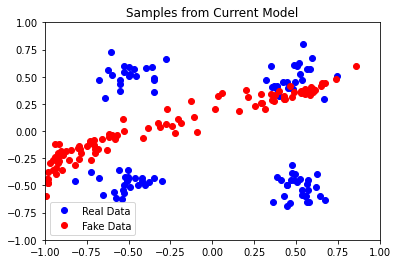


 Epoch : 3900


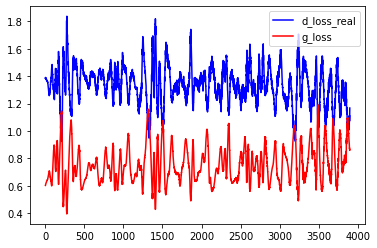


 Epoch : 3900


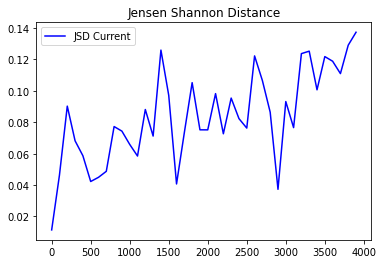

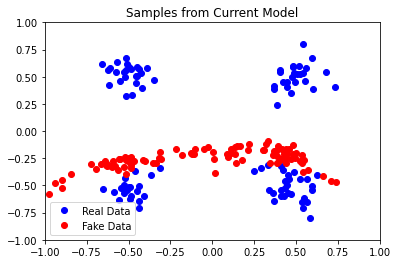


 Epoch : 4000


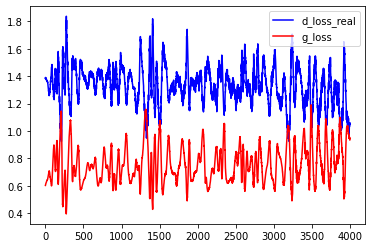


 Epoch : 4000


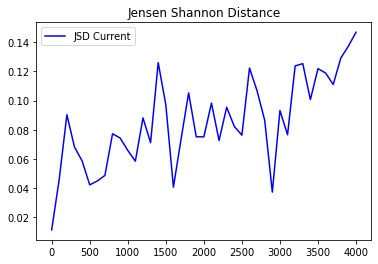

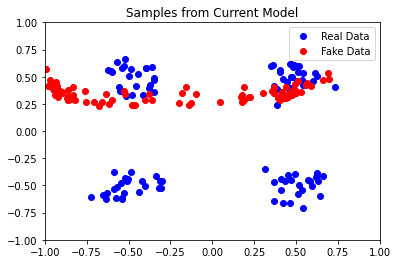


 Epoch : 4100


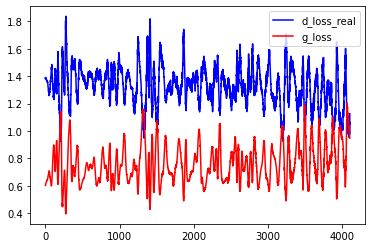


 Epoch : 4100


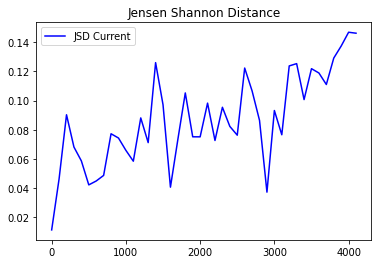

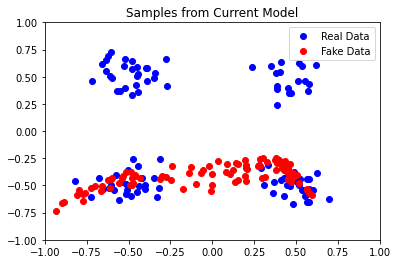


 Epoch : 4200


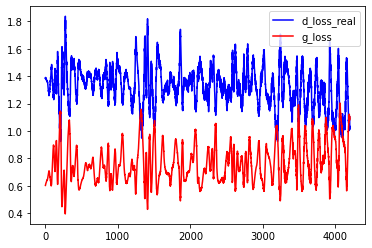


 Epoch : 4200


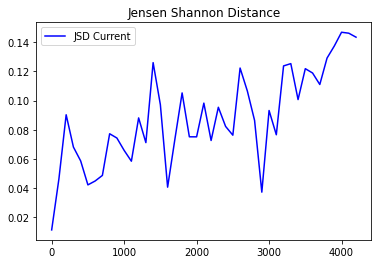

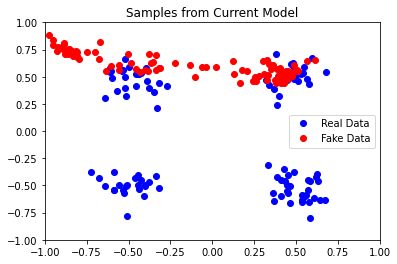


 Epoch : 4300



 Epoch : 4300


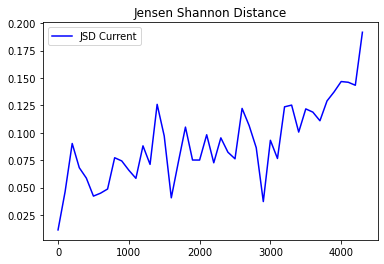

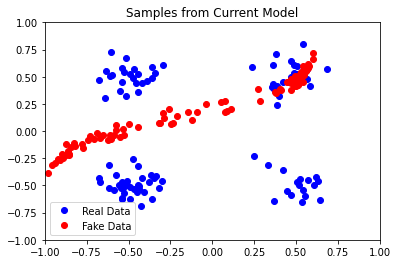


 Epoch : 4400


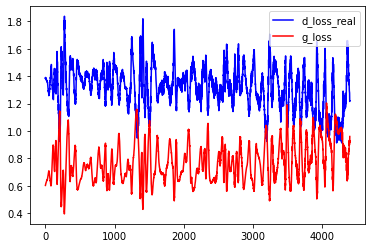


 Epoch : 4400


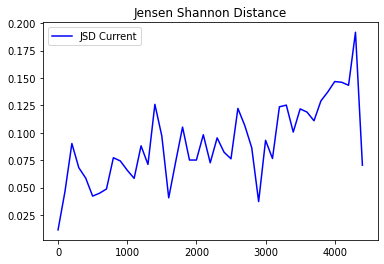

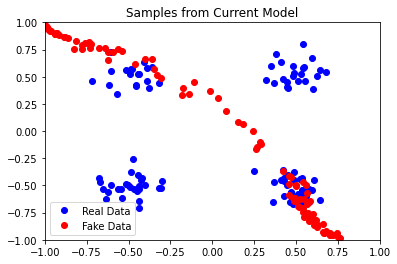


 Epoch : 4500


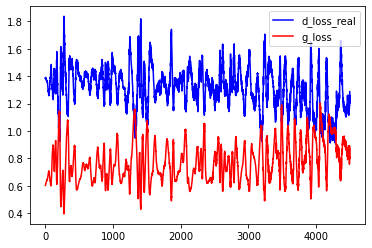


 Epoch : 4500


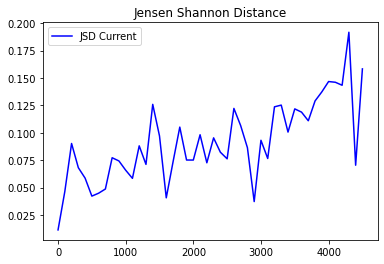

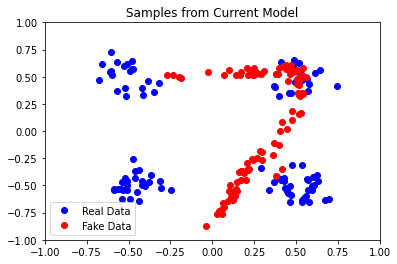


 Epoch : 4600


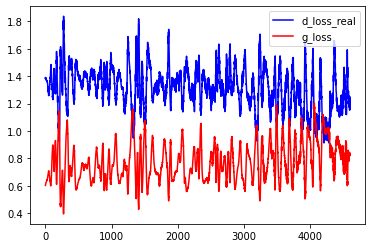


 Epoch : 4600


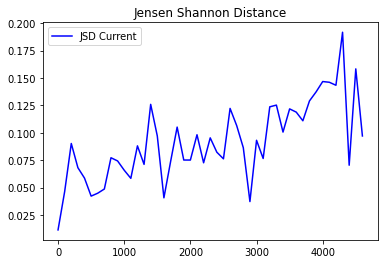

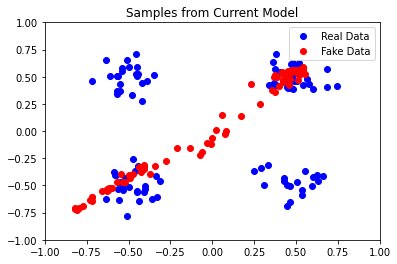


 Epoch : 4700


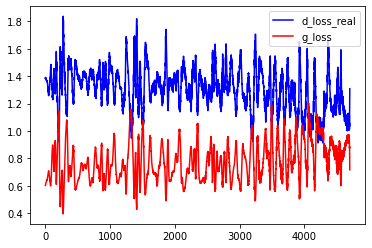


 Epoch : 4700


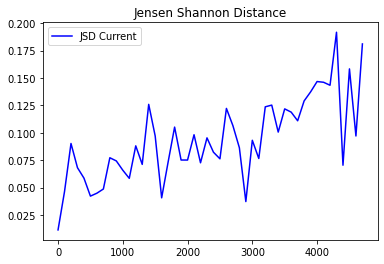

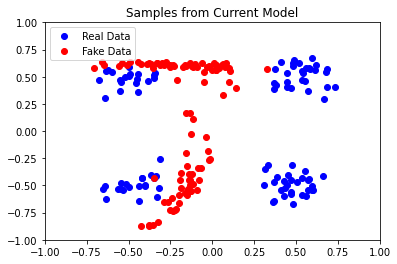


 Epoch : 4800


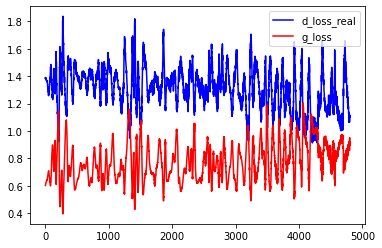


 Epoch : 4800


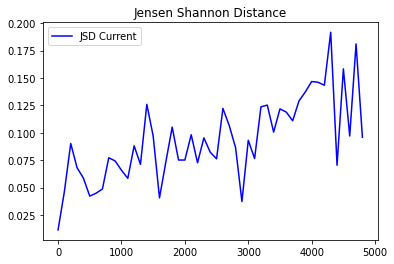

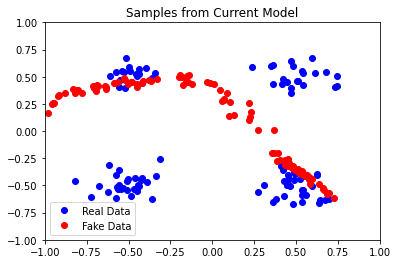


 Epoch : 4900


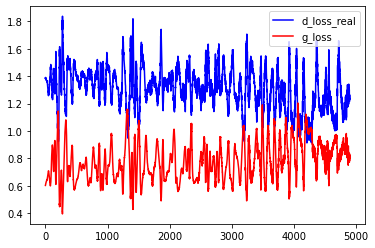


 Epoch : 4900


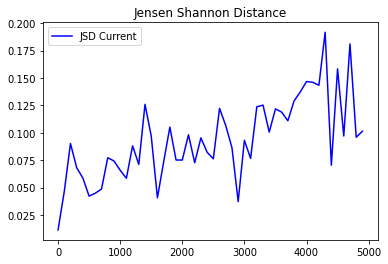

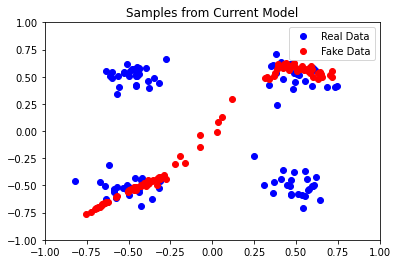


 Epoch : 5000


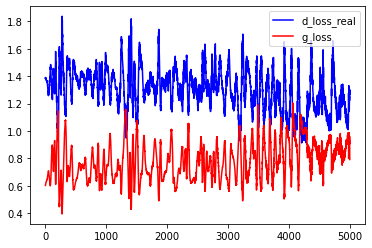


 Epoch : 5000


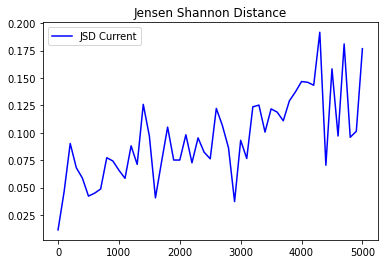

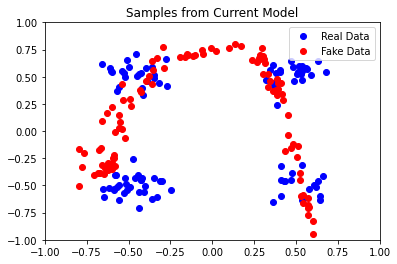


 Epoch : 5100


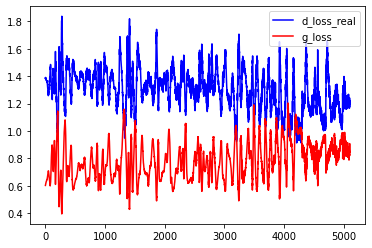


 Epoch : 5100


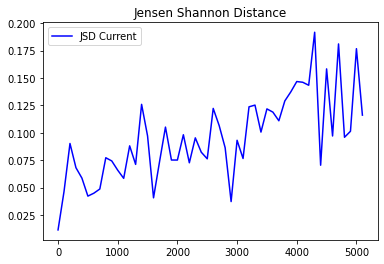

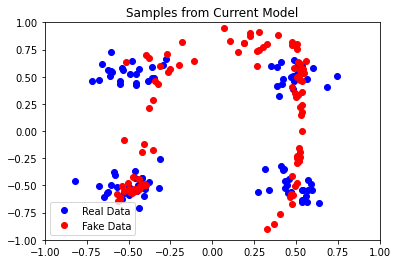


 Epoch : 5200


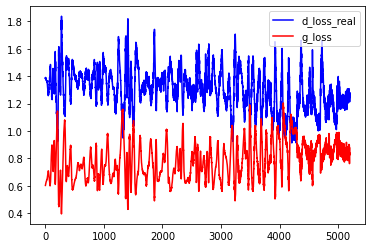


 Epoch : 5200


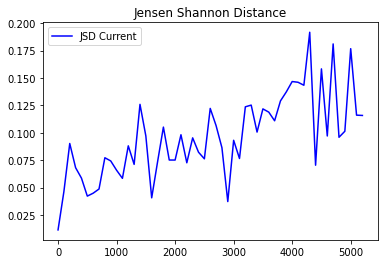

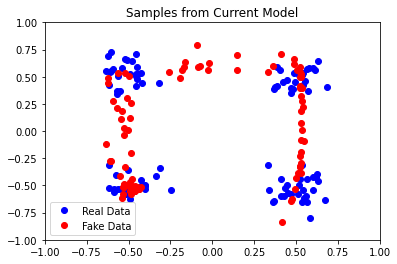


 Epoch : 5300


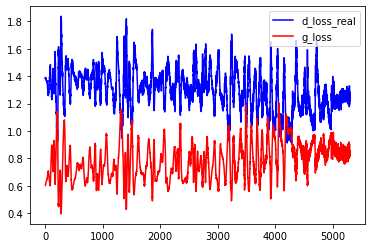


 Epoch : 5300


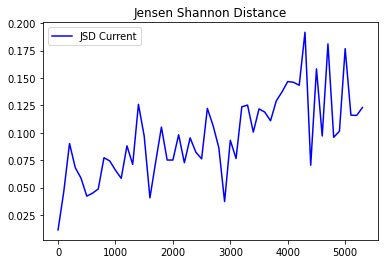

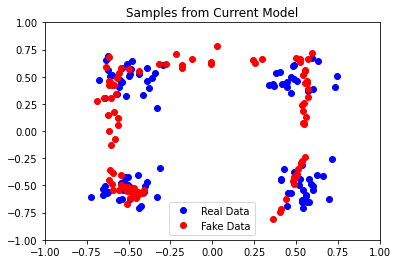


 Epoch : 5400


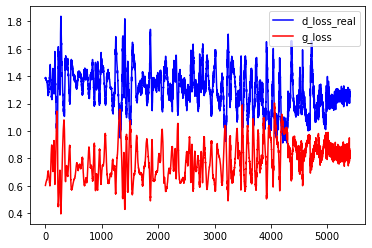


 Epoch : 5400


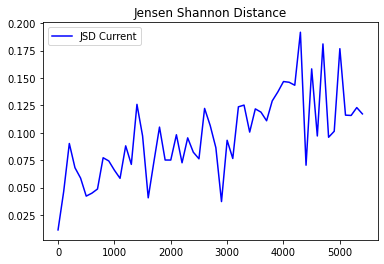

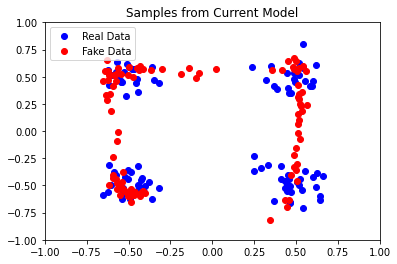


 Epoch : 5500



 Epoch : 5500


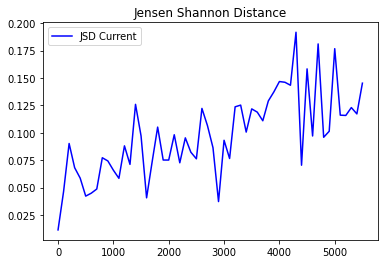


 Epoch : 5600


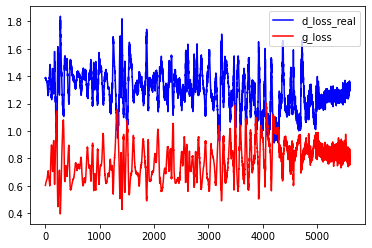


 Epoch : 5600


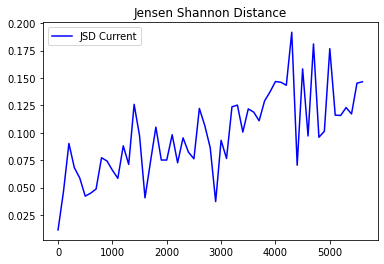

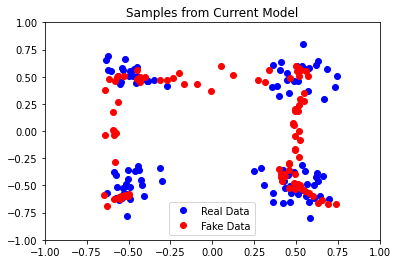


 Epoch : 5700


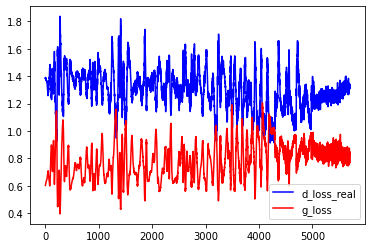


 Epoch : 5700


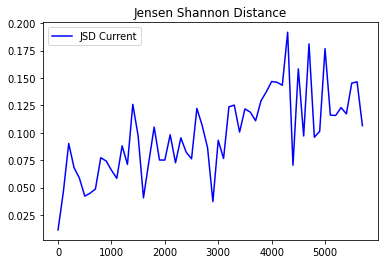

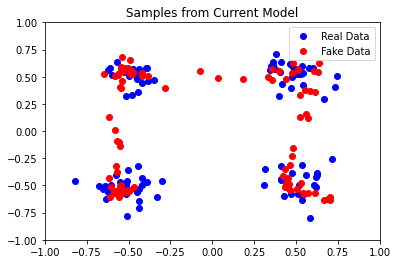


 Epoch : 5800


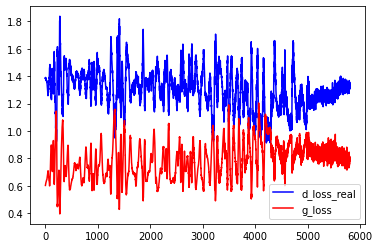


 Epoch : 5800


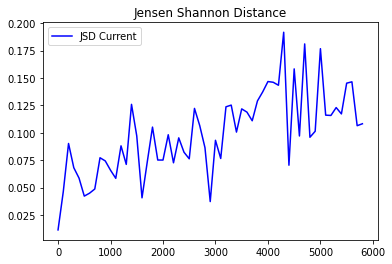

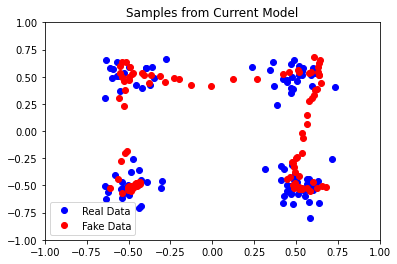


 Epoch : 5900


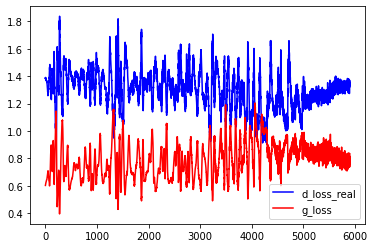


 Epoch : 5900


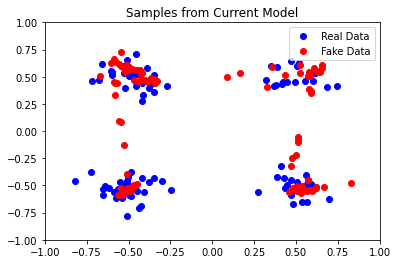


 Epoch : 6000



 Epoch : 6000


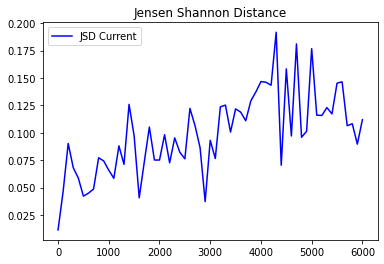

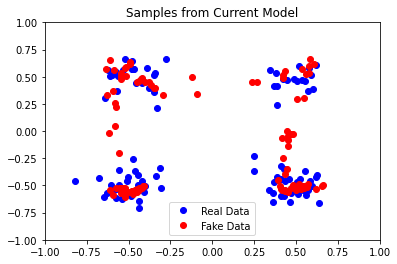


 Epoch : 6100



 Epoch : 6100


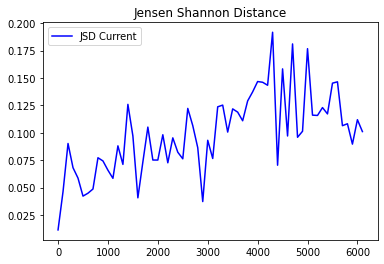

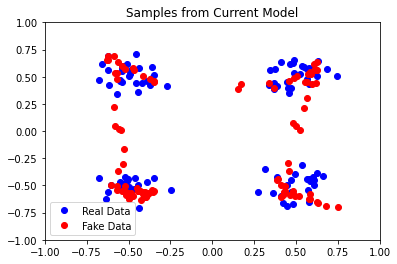


 Epoch : 6200


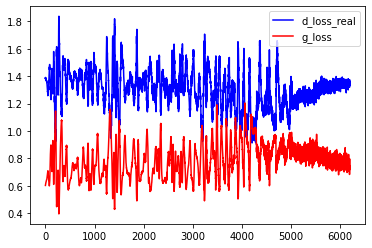


 Epoch : 6200


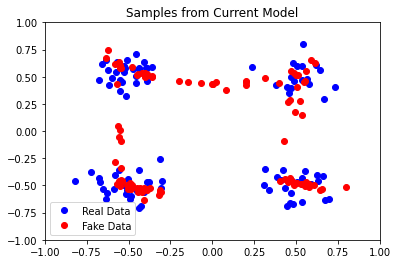


 Epoch : 6300


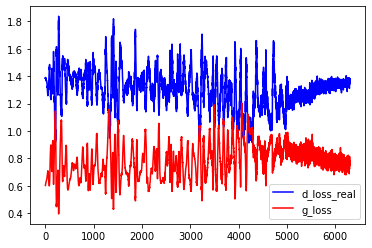


 Epoch : 6300


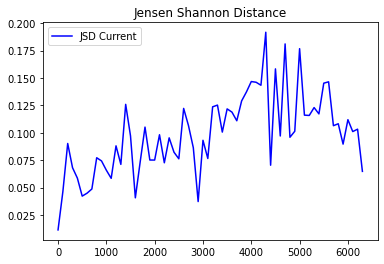

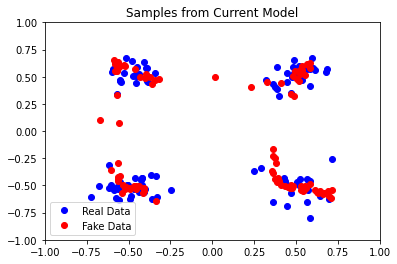


 Epoch : 6400


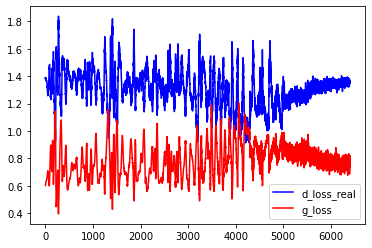


 Epoch : 6400


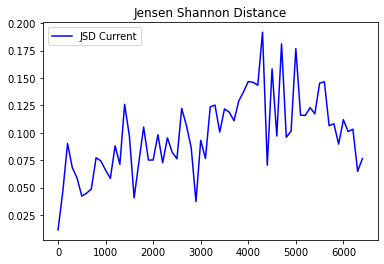


 Epoch : 6500


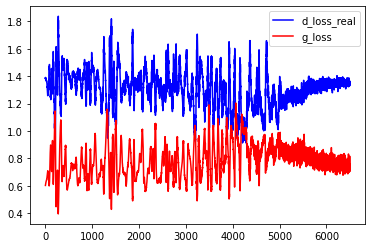


 Epoch : 6500


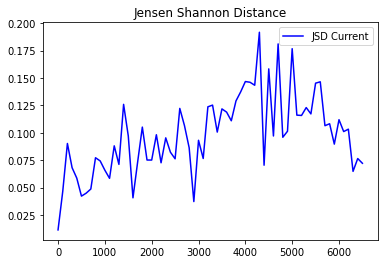


 Epoch : 6600



 Epoch : 6600



 Epoch : 6700



 Epoch : 6700


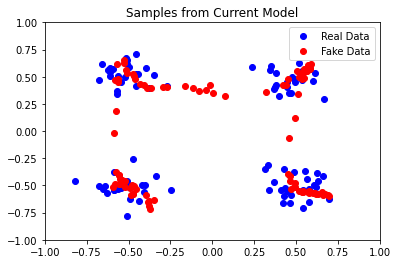


 Epoch : 6800


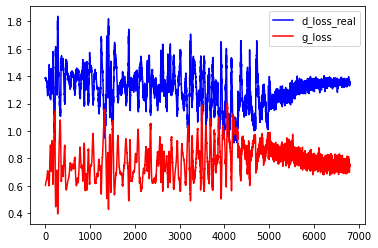


 Epoch : 6800


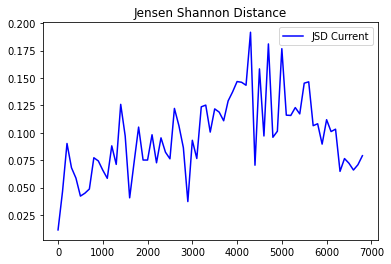

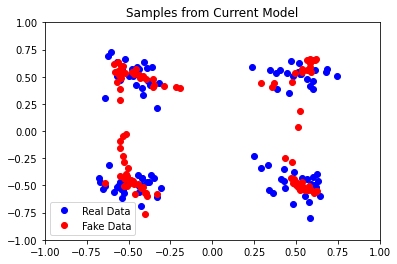


 Epoch : 6900


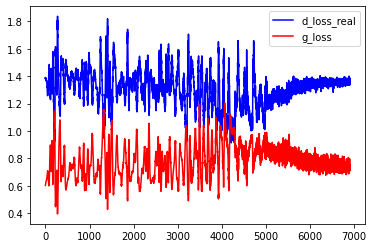


 Epoch : 6900


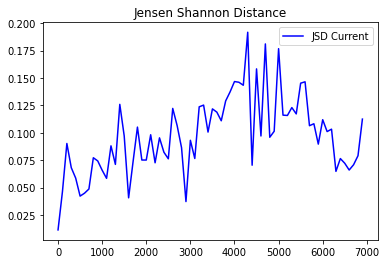

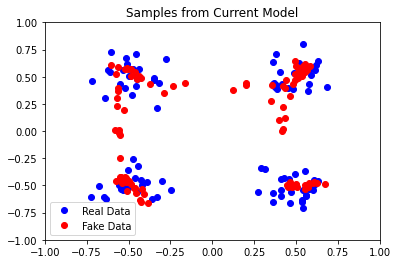


 Epoch : 7000


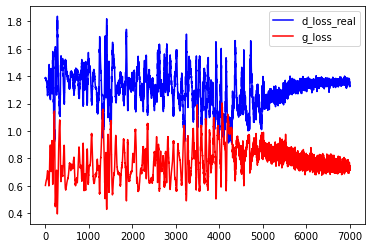


 Epoch : 7000


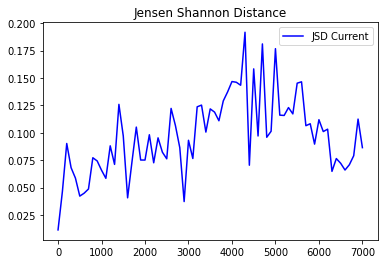

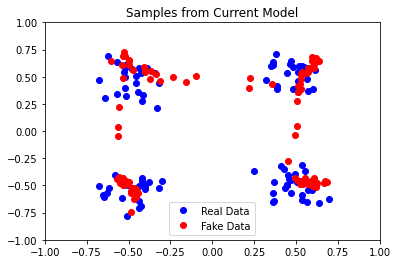


 Epoch : 7100


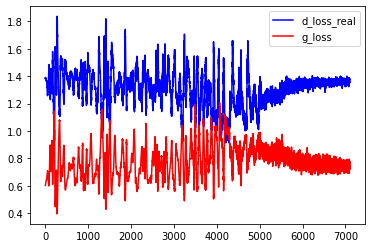


 Epoch : 7100


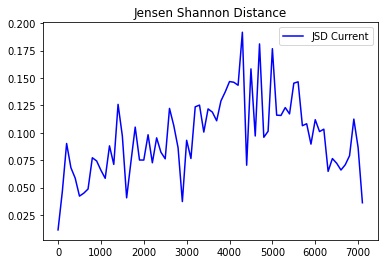

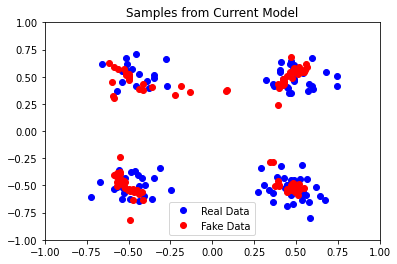


 Epoch : 7200


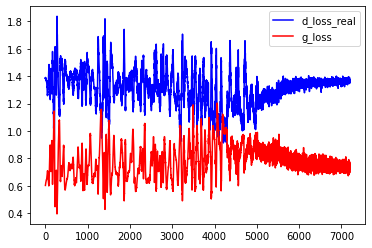


 Epoch : 7200


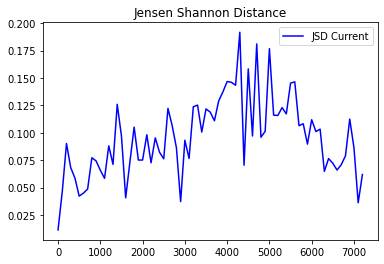

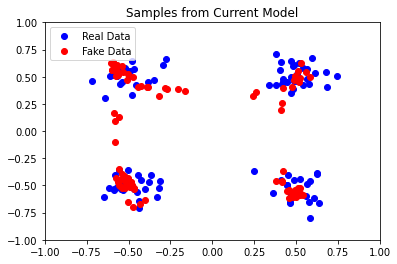


 Epoch : 7300


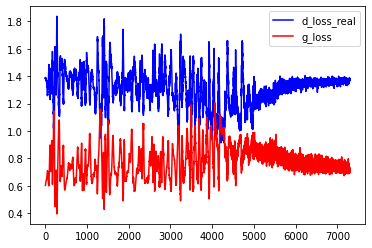


 Epoch : 7300


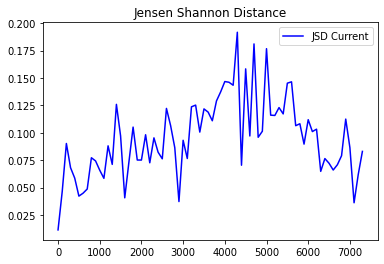


 Epoch : 7400



 Epoch : 7400


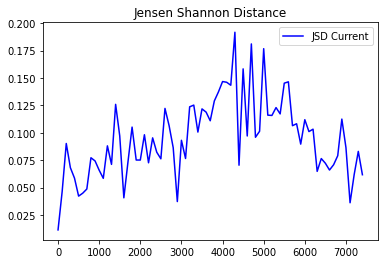

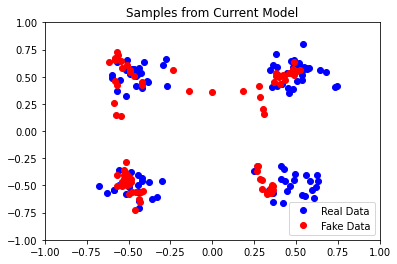


 Epoch : 7500


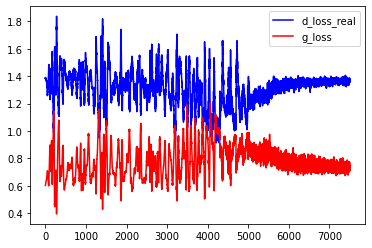


 Epoch : 7500


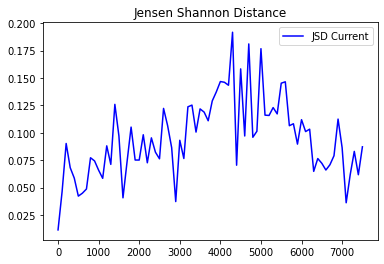


 Epoch : 7600



 Epoch : 7600


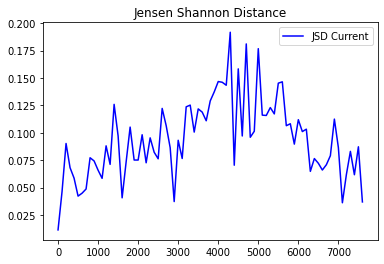

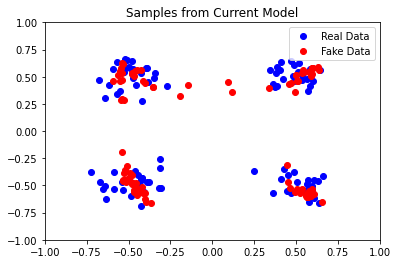


 Epoch : 7700


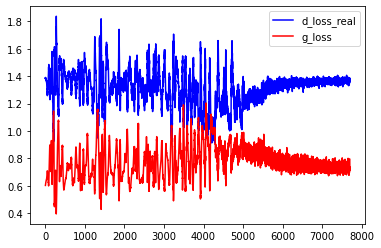


 Epoch : 7700


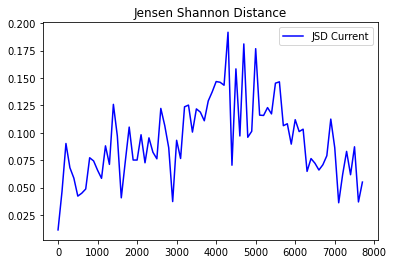

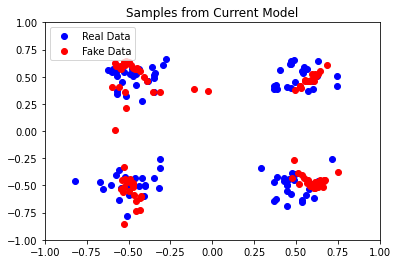


 Epoch : 7800



 Epoch : 7800


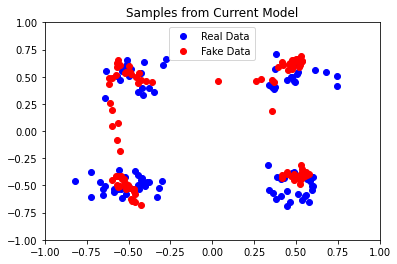


 Epoch : 7900


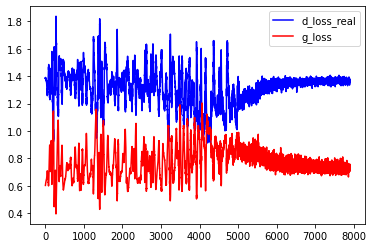


 Epoch : 7900


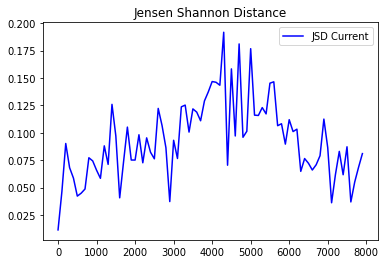


 Epoch : 8000



 Epoch : 8000


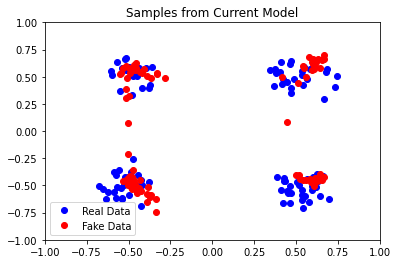


 Epoch : 8100


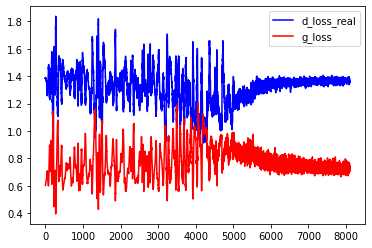


 Epoch : 8100


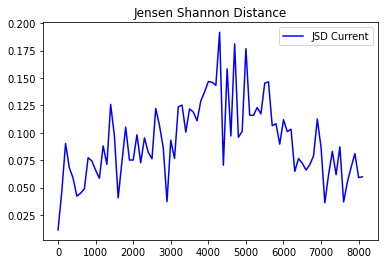

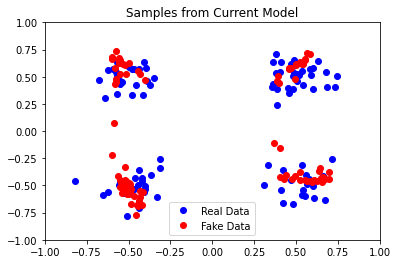


 Epoch : 8200


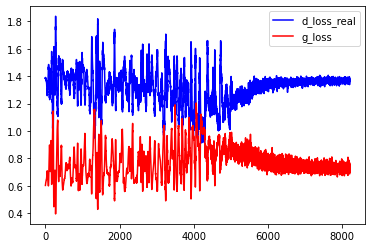


 Epoch : 8200


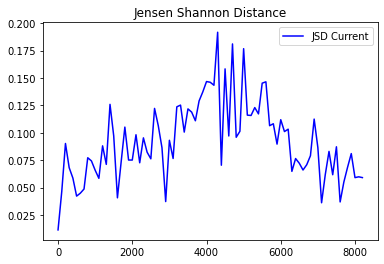

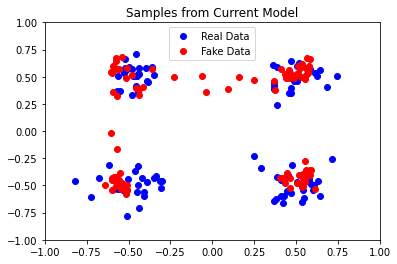


 Epoch : 8300


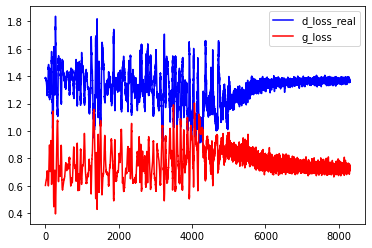


 Epoch : 8300


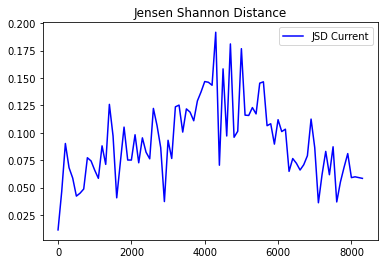

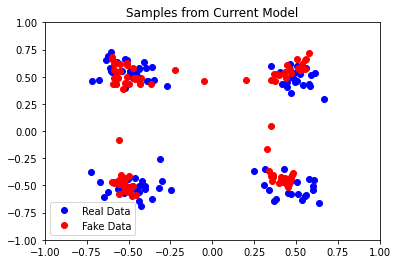


 Epoch : 8400


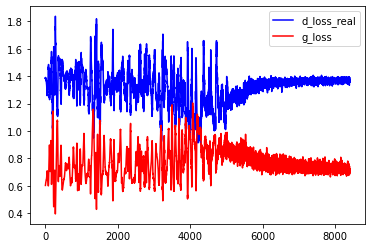


 Epoch : 8400


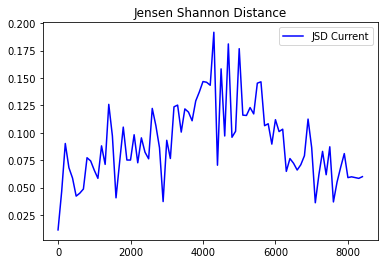

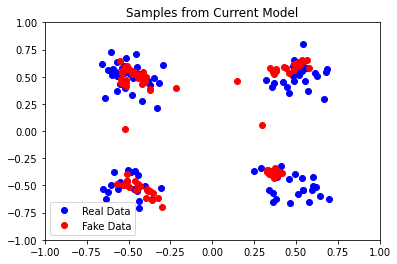


 Epoch : 8500


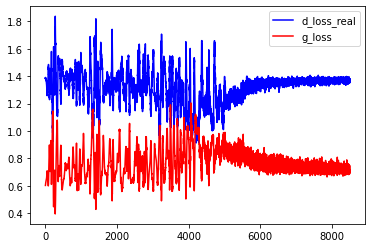


 Epoch : 8500


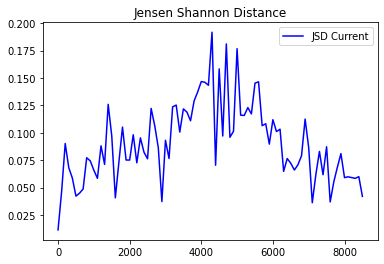

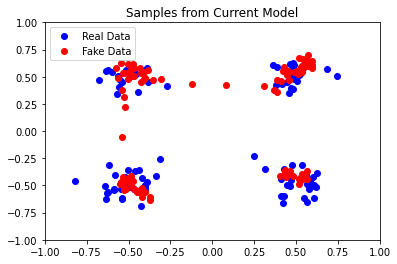


 Epoch : 8600


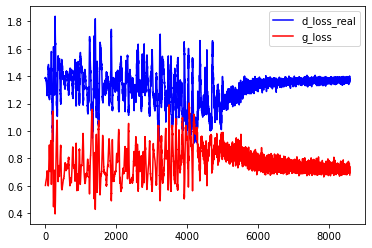


 Epoch : 8600


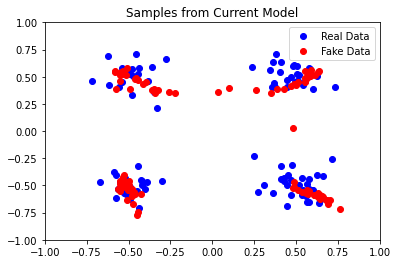


 Epoch : 8700


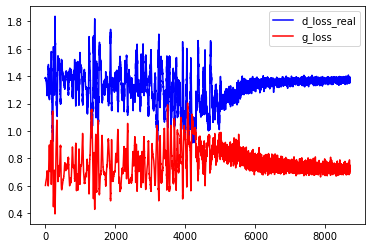


 Epoch : 8700


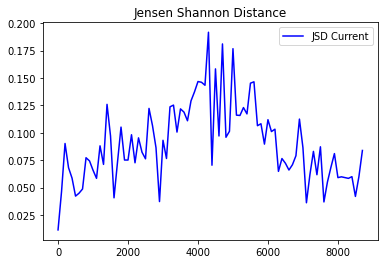

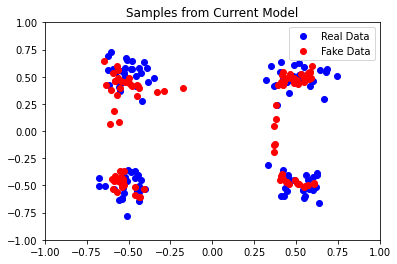


 Epoch : 8800


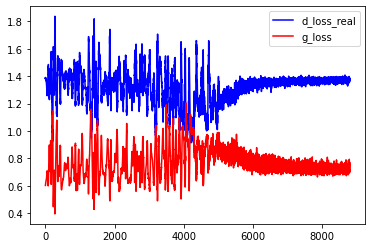


 Epoch : 8800


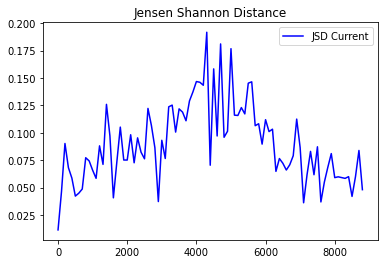

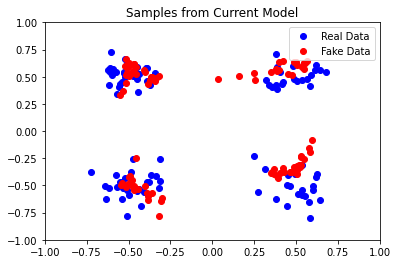


 Epoch : 8900



 Epoch : 8900



 Epoch : 9000


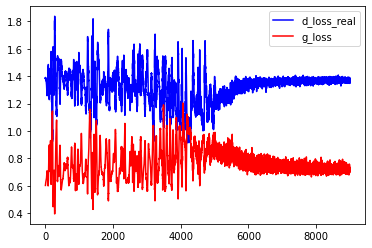


 Epoch : 9000


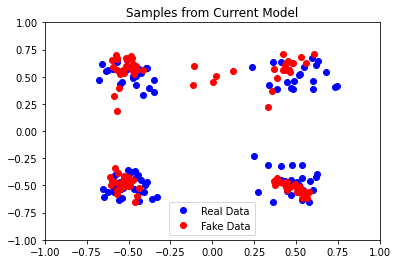


 Epoch : 9100


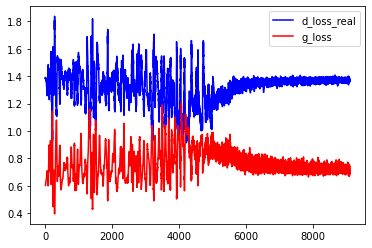


 Epoch : 9100


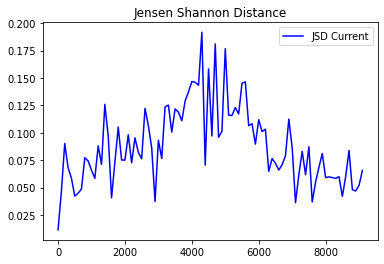

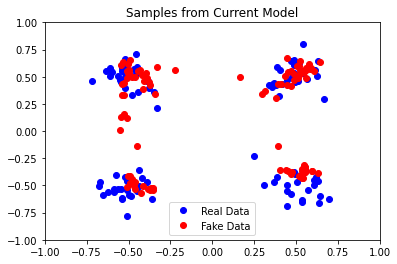


 Epoch : 9200


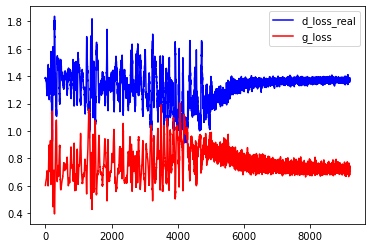


 Epoch : 9200


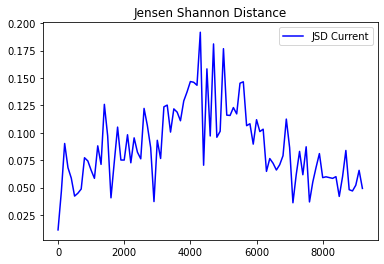

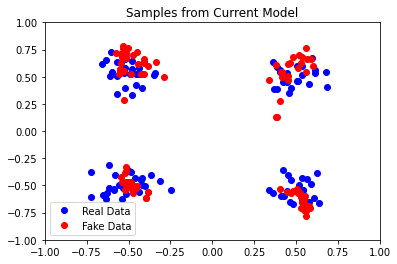


 Epoch : 9300


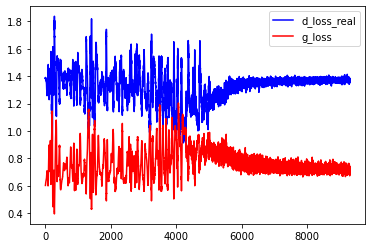


 Epoch : 9300


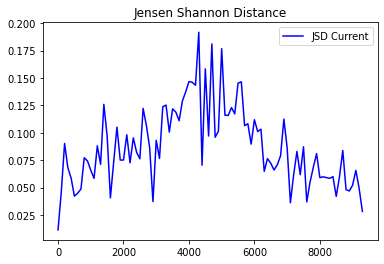

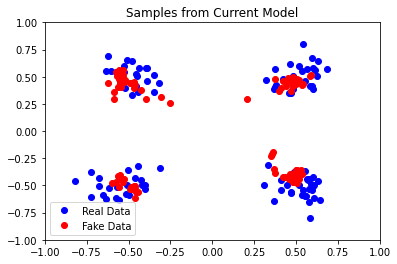


 Epoch : 9400


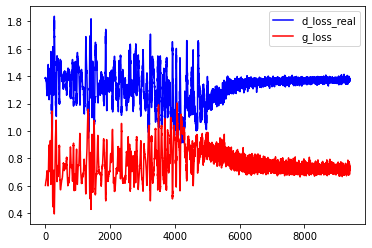


 Epoch : 9400


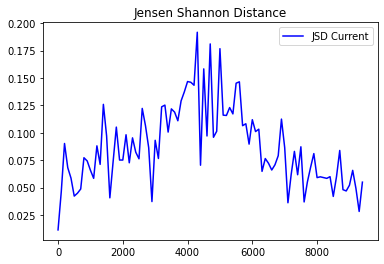

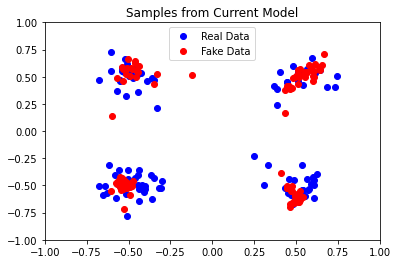


 Epoch : 9500


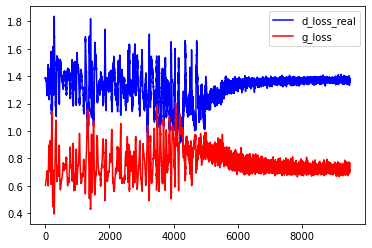


 Epoch : 9500


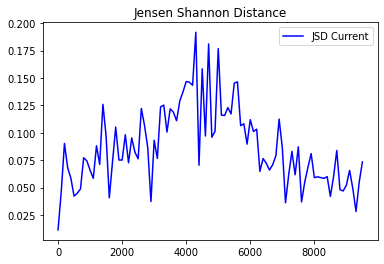

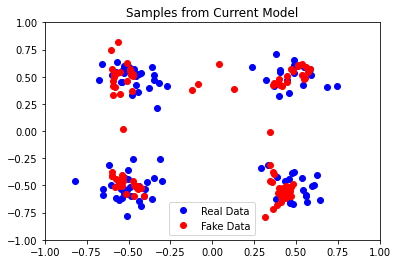


 Epoch : 9600


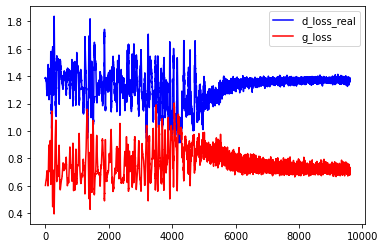


 Epoch : 9600


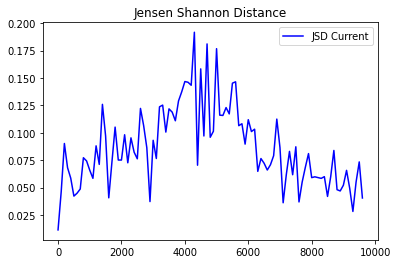

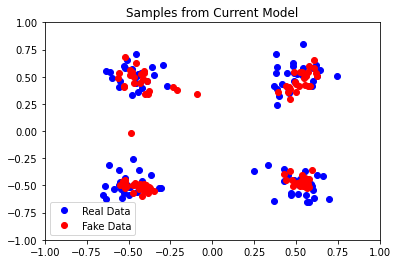


 Epoch : 9700


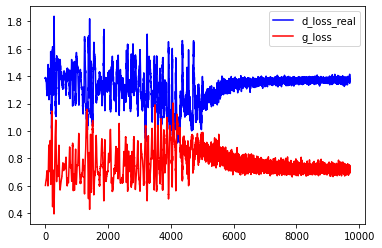


 Epoch : 9700


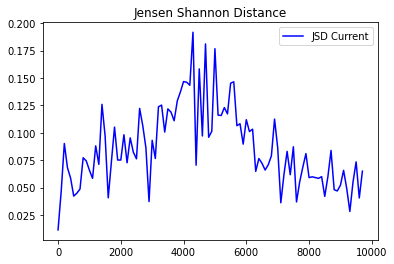

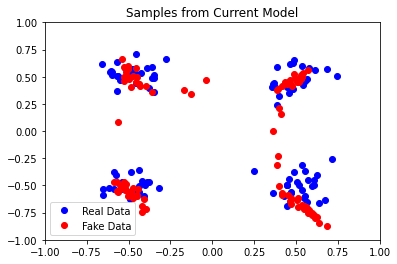


 Epoch : 9800


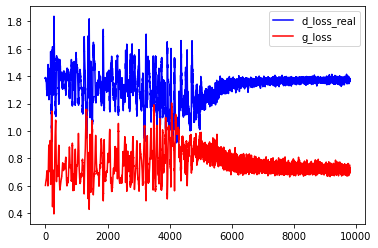


 Epoch : 9800


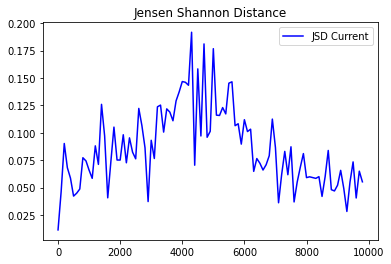

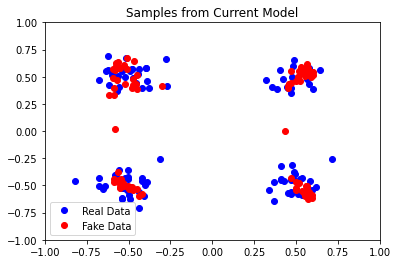


 Epoch : 9900


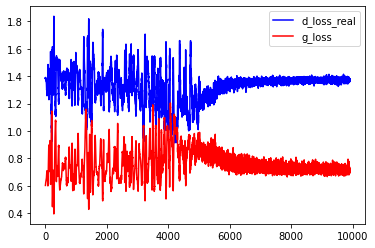


 Epoch : 9900


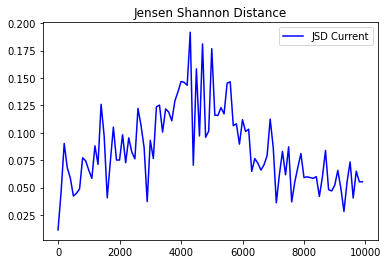

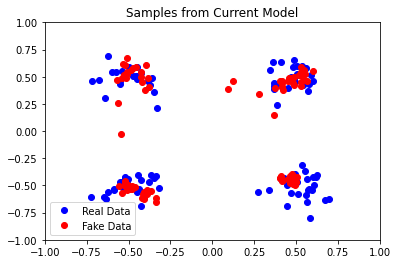

In [21]:
hyperparam = {
  # Device configuration
  "device" : torch.device('cuda' if torch.cuda.is_available() else 'cpu'),

  "latent_size" : 8,
  "hidden_size" : 32,
  "data_dim" : 2,
  "num_epochs" : 10000,
  "batch_size" : 100,
  "lr" : 0.0002,

  # Averaging schedule (ony one of epoch_avg and baatch_avg can be true)
  "epoch_avg" : True,
  "epoch_step" : 1,
  "batch_avg" : False,
  "batch_step" : 1,

  # When plotting, smaplee theese many points from the current model
  "plot_batch_size" : 100,
  "plot_epoch" : 100,
  "print_after_batches" : 100
}

# Discriminator
D = nn.Sequential(
    nn.Linear(hyperparam["data_dim"], hyperparam["hidden_size"]),
    nn.LeakyReLU(0.2),
    nn.Linear(hyperparam["hidden_size"], hyperparam["hidden_size"]),
    nn.LeakyReLU(0.2),
    nn.Linear(hyperparam["hidden_size"], 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(hyperparam["latent_size"], hyperparam["hidden_size"]),
    nn.ReLU(),
    nn.Linear(hyperparam["hidden_size"], hyperparam["hidden_size"]),
    nn.ReLU(),
    nn.Linear(hyperparam["hidden_size"], hyperparam["data_dim"]),
    nn.Tanh())

# Device setting
D = D.to(hyperparam["device"])
G = G.to(hyperparam["device"])

opt = {
  # Binary cross entropy loss
  "criterion" : nn.BCELoss(),
  "d_optimizer" : torch.optim.Adam(D.parameters(), lr=hyperparam["lr"]),
  "g_optimizer" : torch.optim.Adam(G.parameters(), lr=hyperparam["lr"])
}

ds = MixGaussian2D(4, [[0.5,-0.5], [0.5,0.5], [-0.5,-0.5], [-0.5,0.5]], [100, 100, 100, 100], cov_factor = 0.01)
D, G = train_gan(ds, D, G, hyperparam, opt)

In [0]:
G_copy = copy.deepcopy(G)
D_copy = copy.deepcopy(D)

In [23]:
for param, weights in G_copy.items():
  print(param)

AttributeError: ignored

In [29]:
print(G_copy.state_dict())

OrderedDict([('0.weight', tensor([[-0.0422,  0.1231,  0.1018,  0.0545, -0.0405, -0.1101,  0.0460,  0.1038],
        [-0.0727,  0.2064,  0.1707,  0.0920, -0.0677, -0.1867,  0.0795,  0.1748],
        [-0.0880,  0.2172,  0.1876,  0.1125, -0.0820, -0.1801,  0.1007,  0.1815],
        [-0.0877,  0.0877,  0.1606,  0.0579, -0.0263, -0.0827, -0.0060,  0.0854],
        [ 0.1479,  0.0528, -0.1750, -0.0790, -0.0533, -0.0918,  0.0173, -0.0172],
        [ 0.1370, -0.3431, -0.2935, -0.1692,  0.1325,  0.2869, -0.1483, -0.2802],
        [-0.1053,  0.0092, -0.0367, -0.0108,  0.1134,  0.0211,  0.0542,  0.0513],
        [-0.0276,  0.0733,  0.0686,  0.0412, -0.0050, -0.1371,  0.0359,  0.0598],
        [-0.0509,  0.2342,  0.1346,  0.0944, -0.0772, -0.1863,  0.1138,  0.1731],
        [-0.1024,  0.1306,  0.1752,  0.1824,  0.1520, -0.1394,  0.0945,  0.1137],
        [-0.0950,  0.2762,  0.2278,  0.1214, -0.0931, -0.2469,  0.1030,  0.2305],
        [ 0.0985, -0.2333, -0.1982, -0.1182,  0.0938,  0.1902, -0.1067, 

#Autoencoder